# Compute dataset of ratios for Stumpf Model With atmosphericaly corrected (Acolite 18.06) surface reflectances 

In [26]:
%matplotlib inline

import sys
import os
sys.path.append("../../../../")

import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from PIL import Image

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp

from sklearn.cluster import KMeans

(7770, 9042)
(7770, 9042)
(7770, 9042)
(7770, 9042)
(7770, 9042)
(7770, 9042, 5)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


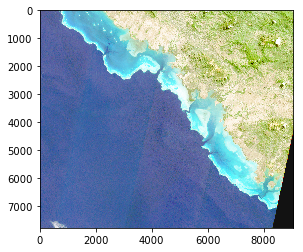

In [27]:
ImagesFolder = '../../../Images/Acolite/S2B_MSIL1C_20170825T231849_N0205_R001_T58KDB/'
raster_wavelength = ['442','492','559','665', '704']
Band = ['ExtraBlue', 'Blue', 'Green', 'Red', 'ExtraRed']
raster_Name = ['S2B_MSI_2017_08_25_23_18_49_T58KDB_rhos_' + f + '.tif' for f in raster_wavelength]
bands_data = []

for f in range(len(raster_Name)):
    raster_dataset = gdal.Open(ImagesFolder+raster_Name[f], gdal.GA_ReadOnly)
    for b in range(1, raster_dataset.RasterCount+1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())

for i in range(len(bands_data)):
    print(bands_data[i].shape)
bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
print(bands_data.shape)


raster_dataset = gdal.Open(ImagesFolder+raster_Name[2], gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()

VisuRGB = bands_data[:,:,np.array([3,2,1])]
VisuRGB[np.isnan(VisuRGB)] = 0
plt.imshow(exposure.equalize_hist(VisuRGB))
del VisuRGB

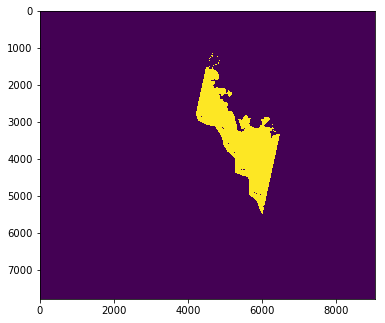

In [28]:
ShapeFolder = '../../ShapesAndMask/'
GlobalShapeFolder = '../../../Shapes/'
SoilIndex = 'Masks/GlobalSoil_From_Foot3.tif'
ShadowCloudIndex = 'Masks/CloudShadowManuallyChecked.shp'
ROI = 'ROI.shp'
OpenOcean = 'OpenOcean.shp'
Lagoon = 'Lagoon.tif'

ROI = mgp.create_mask_from_vector(ShapeFolder + ROI, cols, rows, geo_transform, proj, target_value=1, format=gdal.GDT_Byte)
ROI = ROI.GetRasterBand(1).ReadAsArray().astype(bool)

OpenOcean = mgp.create_mask_from_vector(GlobalShapeFolder + OpenOcean, cols, rows, geo_transform, proj, target_value=1, format=gdal.GDT_Byte)
OpenOcean = OpenOcean.GetRasterBand(1).ReadAsArray().astype(bool)

#ShadowCloudIndex = mgp.create_mask_from_vector(ImagesFolder + ShadowCloudIndex, cols, rows, geo_transform, proj, target_value=1, format=gdal.GDT_Byte)
#ShadowCloudIndex = ShadowCloudIndex.GetRasterBand(1).ReadAsArray().astype(bool)

SoilIndex = gdal.Open(ImagesFolder + SoilIndex, gdal.GA_ReadOnly)
SoilIndex =SoilIndex.GetRasterBand(1).ReadAsArray().astype(bool)

ClassifyIndex = ~SoilIndex * ~OpenOcean * ROI # * ~ShadowCloudIndex
#================================================================
#ClassifyIndex[:,:] = False # to modify for each application
#================================================================
mgp.write_raster2(ShapeFolder + Lagoon, ClassifyIndex, geo_transform, proj, DriverName="GTiff", formatMem=gdal.GDT_Byte )

ClassifyIndex = gdal.Open(ShapeFolder + Lagoon, gdal.GA_ReadOnly)
ClassifyIndex = ClassifyIndex.GetRasterBand(1).ReadAsArray().astype(bool)

fig = plt.figure( figsize=(6, 6))
plt.imshow(ClassifyIndex)
del ROI, OpenOcean, ShadowCloudIndex

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


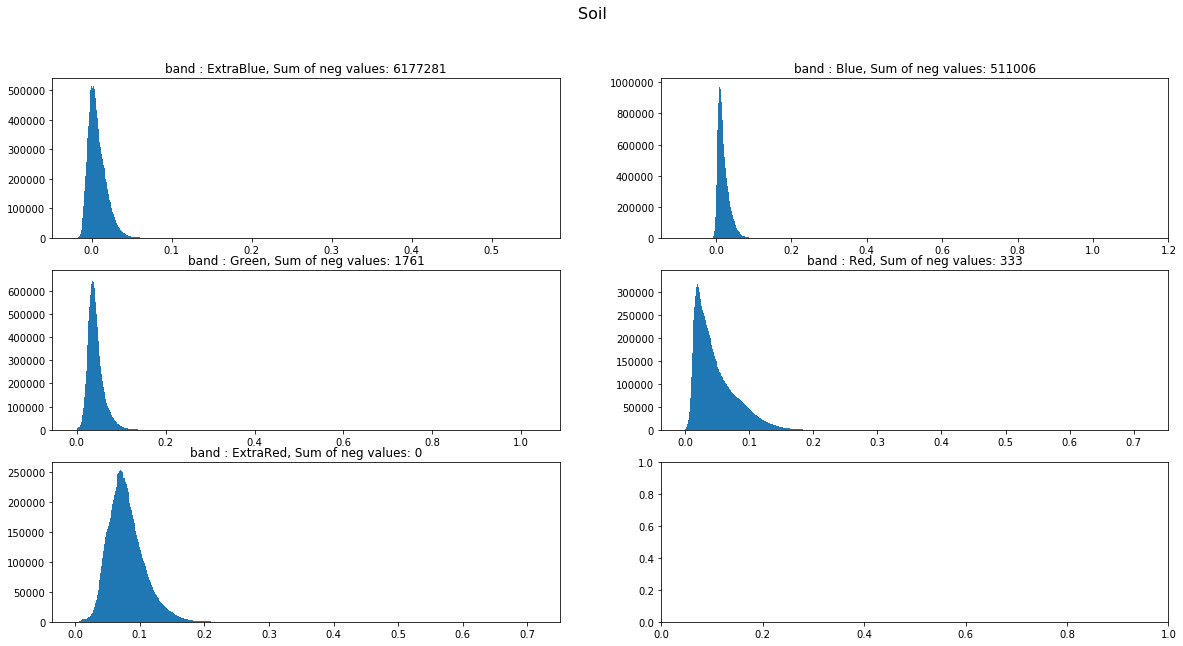

In [29]:

fig, axes = plt.subplots(3,2, figsize=(20,10))
plt.suptitle('Soil', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i>4:
        break
    ax.set_title('band : '+Band[i]+', Sum of neg values: '+ str(np.sum(bands_data[SoilIndex,i].ravel()<0)))
    ax.hist(bands_data[SoilIndex,i][~np.isnan(bands_data[SoilIndex,i])].ravel(), bins=1000)
del SoilIndex    

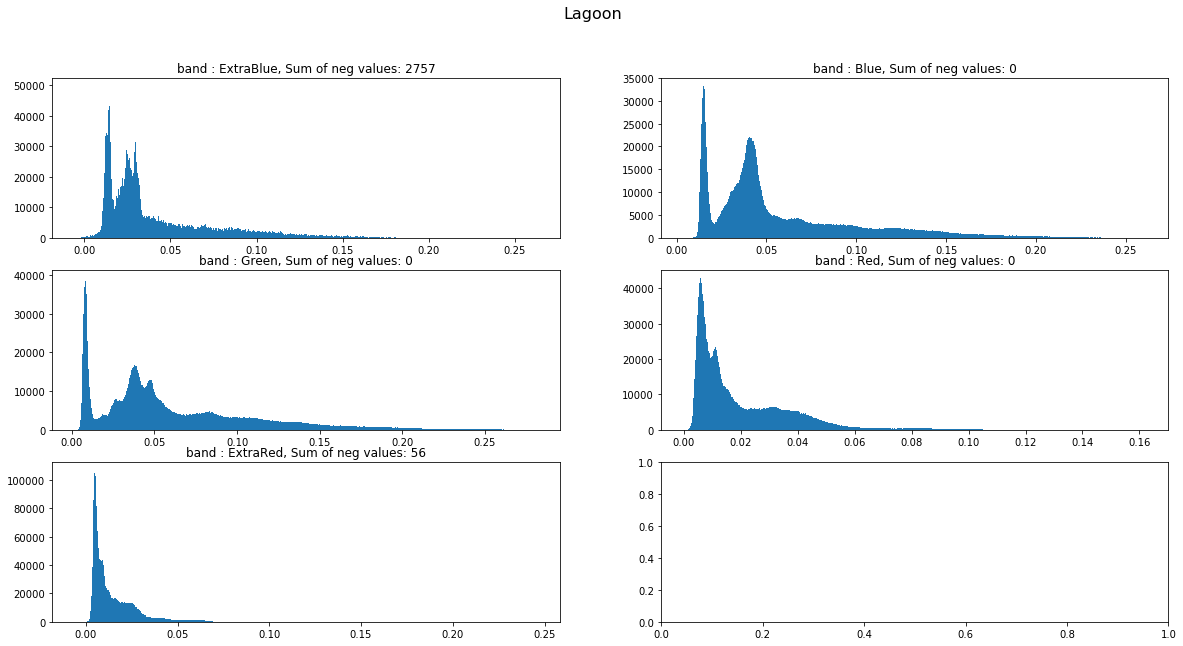

In [30]:

fig , axes = plt.subplots(3,2, figsize=(20,10))
plt.suptitle('Lagoon', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i>4:
        break
    ax.set_title('band : '+Band[i]+', Sum of neg values: '+ str(np.sum(bands_data[ClassifyIndex,i].ravel()<0)))
    ax.hist(bands_data[ClassifyIndex,i].ravel(), bins=1000)

In [31]:
for i in range(5):
    print('Minimum value in band ',i,': ',np.min(bands_data[ClassifyIndex,i]))
    print('Maximum value in band ',i,': ',np.max(bands_data[ClassifyIndex,i]))
    print('Number negative value in band ',i,': ',np.sum(bands_data[ClassifyIndex,i]<0))
    print('Number initial nan value in band ',i,': ',np.sum(np.isnan(bands_data[ClassifyIndex,i])))
    FalseIndex = bands_data[:,:,i]<=0
    bands_data[np.logical_and(FalseIndex,ClassifyIndex),i] = np.nan
    print("="*10)

Minimum value in band  0 :  -0.00509384
Maximum value in band  0 :  0.262612
Number negative value in band  0 :  2757
Number initial nan value in band  0 :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


Minimum value in band  1 :  0.00429596
Maximum value in band  1 :  0.260916
Number negative value in band  1 :  0
Number initial nan value in band  1 :  0
Minimum value in band  2 :  0.00219399
Maximum value in band  2 :  0.281354
Number negative value in band  2 :  0
Number initial nan value in band  2 :  0
Minimum value in band  3 :  7.48133e-05
Maximum value in band  3 :  0.162112
Number negative value in band  3 :  0
Number initial nan value in band  3 :  0
Minimum value in band  4 :  -0.00561173
Maximum value in band  4 :  0.245716
Number negative value in band  4 :  56
Number initial nan value in band  4 :  0


# Warning: Checking for multiplicator n

In [33]:
n = 1000.0
if not n > np.max([1.0/np.nanmin(bands_data[ClassifyIndex,i]) for i in range(bands_data.shape[2])]):
    n = 100.0 + np.max([1.0/np.nanmin(bands_data[ClassifyIndex,i]) for i in range(bands_data.shape[2])])

LagoonData = np.full(bands_data.shape, np.nan, np.float)
LagoonData[ClassifyIndex,:] = bands_data[ClassifyIndex,:]
del bands_data

LagoonData[ClassifyIndex,:] = np.log(n * LagoonData[ClassifyIndex,:])

In [34]:
count=1

data = {}
for i in range(LagoonData.shape[2]-1,-1,-1):
    for i2 in range(i-1,-1,-1):
        data[Band[i2], Band[i]] = count
        count = count +1
data

{('Blue', 'ExtraRed'): 3,
 ('Blue', 'Green'): 8,
 ('Blue', 'Red'): 6,
 ('ExtraBlue', 'Blue'): 10,
 ('ExtraBlue', 'ExtraRed'): 4,
 ('ExtraBlue', 'Green'): 9,
 ('ExtraBlue', 'Red'): 7,
 ('Green', 'ExtraRed'): 2,
 ('Green', 'Red'): 5,
 ('Red', 'ExtraRed'): 1}

In [35]:
Band = ['ExtraBlue', 'Blue', 'Green', 'Red', 'ExtraRed']
count=1

data = {}
for i in range(LagoonData.shape[2]-1,-1,-1):
    for i2 in range(i-1,-1,-1):
        data[Band[i2], Band[i]] = np.divide(LagoonData[:,:,i2], LagoonData[:,:,i])
        count = count +1
del LagoonData

In [36]:
for i in data.keys():
    print('Band :',i)
    print('Number of equality value: ',np.sum(data[i][ClassifyIndex]==1.000))
    print('Number of NaN value: ',np.sum(np.isnan(data[i][ClassifyIndex])))
    print('Interval of value: ',np.nanmax(data[i][ClassifyIndex]) - np.nanmin(data[i][ClassifyIndex]))
    print("="*10)

Band : ('Red', 'ExtraRed')
Number of equality value:  0
Number of NaN value:  56
Interval of value:  1.49061863344
Band : ('Green', 'ExtraRed')
Number of equality value:  0
Number of NaN value:  56
Interval of value:  1.83288229304
Band : ('Blue', 'ExtraRed')
Number of equality value:  0
Number of NaN value:  56
Interval of value:  1.88741705088
Band : ('ExtraBlue', 'ExtraRed')
Number of equality value:  0
Number of NaN value:  2813
Interval of value:  2.61821142355
Band : ('Green', 'Red')
Number of equality value:  0
Number of NaN value:  0
Interval of value:  1.44127896889
Band : ('Blue', 'Red')
Number of equality value:  0
Number of NaN value:  0
Interval of value:  1.51537434046
Band : ('ExtraBlue', 'Red')
Number of equality value:  0
Number of NaN value:  2757
Interval of value:  2.29253190505
Band : ('Blue', 'Green')
Number of equality value:  1
Number of NaN value:  0
Interval of value:  0.35386424506
Band : ('ExtraBlue', 'Green')
Number of equality value:  0
Number of NaN value

In [37]:
RX = []
for i in data.keys():
    RX.append(data[i])
RecordOrdered_Keys = data.keys()
del data
SRX = np.stack(RX,axis=2)
del RX

In [38]:
np.savez_compressed('../../CompressedData/SRXData_Raw', 
                    Ratios=SRX,
                    FocusIndex=np.full((rows, cols),True), 
                    Keys=[k for k in RecordOrdered_Keys], 
                    ClassifyIndex=ClassifyIndex, 
                    Multiplicator=n, 
                    mode='LowlyAt/HighlyAt')